In [1]:
import torch
import scipy.io as sio
from hamiltonians.Central import MZMVortexHamiltonian
from hamiltonians.Lead import SpinfulLead,SpinlessLead
from greens_functions.direct_calculation import calculate_transport_properties
from dataplot.ldos_plot import plot_ldos_surface, plot_ldos_energy_slice

funcDevice = 'cpu'

# System parameters from the paper
Ny = 10  # Larger system to see vortex effects
Nx = 10
t_y = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)
t_x = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)
mu = torch.tensor(0.6, dtype=torch.complex64, device=funcDevice)
B = torch.tensor(0.0, dtype=torch.complex64, device=funcDevice)
M = torch.tensor(0, dtype=torch.complex64, device=funcDevice)
Delta_0 = torch.tensor(0.2, dtype=torch.complex64, device=funcDevice)
xi_0 = torch.tensor(0.1, dtype=torch.float32, device=funcDevice)
lambda_L = torch.tensor(30.0, dtype=torch.float32, device=funcDevice)
temperature = torch.tensor(1e-6, dtype=torch.float32, device=funcDevice)

# Define vortex positions (for example, two vortices)
# vortex_positions = [(10.5, 10.5)]  # Positions in lattice units
vortex_positions = []  # Positions in lattice units

# Create Hamiltonian with vortices
vortex_hamiltonian = MZMVortexHamiltonian(
    Ny=Ny, 
    Nx=Nx, 
    t_y=t_y,
    t_x=t_x,
    Delta_0=Delta_0,
    xi_0=xi_0,
    lambda_L=lambda_L,
    vortex_positions=vortex_positions,
    mu=mu,
    B=B,
    M=M
)


In [2]:

H_full_BdG = vortex_hamiltonian.H_full_BdG
leads_info=[]   
# Define energy grid for LDOS calculation
E_min, E_max = -1, 1  # Around the gap scale
num_points = 600
E = torch.linspace(E_min, E_max, steps=num_points, dtype=torch.float32, device=funcDevice)
eta = torch.tensor(1e-3, dtype=torch.float32, device=funcDevice)

# Split energy points into chunks
chunk_size = 50  # Adjust chunk size based on memory constraints
num_chunks = (num_points + chunk_size - 1) // chunk_size

# Initialize lists to store results
all_ldos = []
all_rho_electron = []
all_rho_hole = []
all_transmission = []
all_andreev = []
all_current = []
all_noise = []

# Calculate transport properties in chunks
print("Calculating transport properties in chunks...")
for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, num_points)
    E_chunk = E[start_idx:end_idx]
    
    print(f"Processing chunk {i+1}/{num_chunks} (E = {E_chunk[0]:.3f} to {E_chunk[-1]:.3f})")
    
    # Calculate transport properties for this chunk
    chunk_results = calculate_transport_properties(
        E_batch=E_chunk,
        H_total=H_full_BdG,
        leads_info=leads_info,
        temperature=temperature,
        eta=eta
    )
    
    all_ldos.append(chunk_results['rho_e_jj'])
    all_rho_electron.append(chunk_results['rho_electron'])
    all_rho_hole.append(chunk_results['rho_hole'])
    all_transmission.append(chunk_results['transmission'])
    all_andreev.append(chunk_results['andreev'])
    all_current.append(chunk_results['current'])
    all_noise.append(chunk_results['noise'])

# Combine results from all chunks
ldos = torch.cat(all_ldos, dim=0)

# Save results
sio.savemat(f'vortex_ldos_Nx{Nx}_ty{t_y}_tx{t_x}_D{Delta_0}_xi{xi_0}_lam{lambda_L}_mu{mu}_B{B}_M{M}.mat', {
    'ldos': ldos.detach().cpu().numpy(),
    'energy': E.detach().cpu().numpy(),
    'H_full_BdG': H_full_BdG.detach().cpu().numpy()
})


Calculating transport properties in chunks...
Processing chunk 1/12 (E = -1.000 to -0.836)
Processing chunk 2/12 (E = -0.833 to -0.669)
Processing chunk 3/12 (E = -0.666 to -0.503)
Processing chunk 4/12 (E = -0.499 to -0.336)
Processing chunk 5/12 (E = -0.332 to -0.169)
Processing chunk 6/12 (E = -0.165 to -0.002)
Processing chunk 7/12 (E = 0.002 to 0.165)
Processing chunk 8/12 (E = 0.169 to 0.332)
Processing chunk 9/12 (E = 0.336 to 0.499)
Processing chunk 10/12 (E = 0.503 to 0.666)
Processing chunk 11/12 (E = 0.669 to 0.833)
Processing chunk 12/12 (E = 0.836 to 1.000)


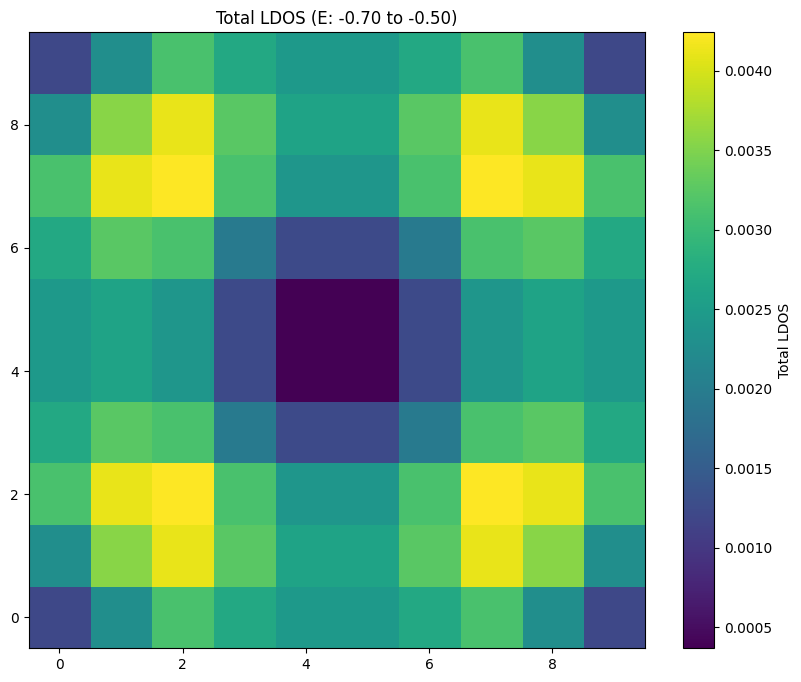

In [3]:

# Plot LDOS
from dataplot.ldos_plot import plot_ldos_surface, plot_ldos_energy_slice

import datetime

# Get the current timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Plot LDOS surface at E=0 (zero energy)
plot_ldos_surface(
    E_values=E,
    rho_jj_values=ldos,
    E_lower=-0.7,
    E_upper=-0.5,
    Nx=Nx,
    Ny=Ny,
    num_orbitals=2,  # spin case
    save_path=f'ldos_surface_E0fvortex_ldos_Nx{Nx}_ty{t_y}_tx{t_x}_D{Delta_0}_xi{xi_0}_lam{lambda_L}_mu{mu}_B{B}_M{M}_{timestamp}.png'
)

# # Plot LDOS at specific energies
# for energy in [0.0, 0.1, -0.1]:
#     plot_ldos_energy_slice(
#         E_values=E,
#         rho_jj_values=ldos,
#         energy=energy,
#         Nx=Nx,
#         Ny=Ny,
#         is_spin=True,
#         save_path=f'ldos_E_{energy:.2f}.png'
#     )

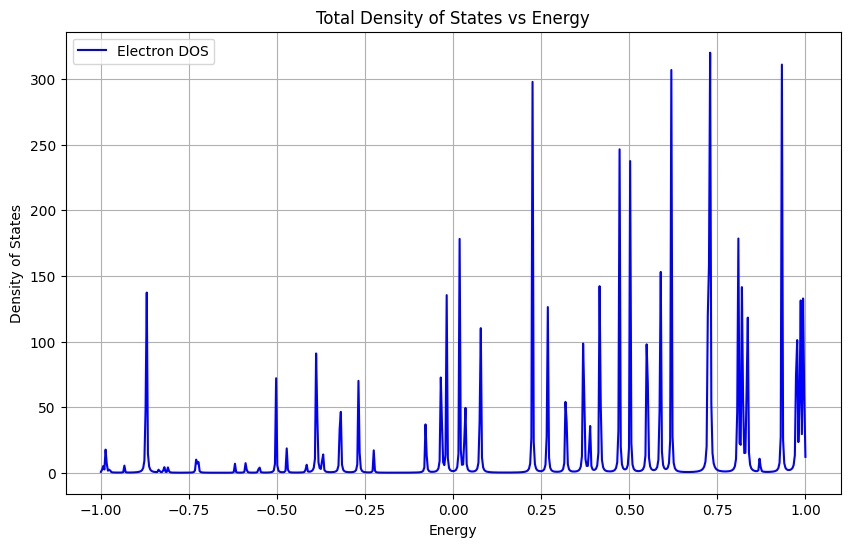

In [4]:
# After calculating results in chunks and combining them
all_rho_electron = torch.cat(all_rho_electron, dim=0)
all_rho_hole = torch.cat(all_rho_hole, dim=0)

# Plot total DOS
from dataplot.ldos_plot import plot_total_dos

plot_total_dos(
    E_values=E,
    rho_electron=all_rho_electron,
    rho_hole=None,
    save_path='total_dos.png'
)

In [5]:
# Calculate the integrated DOS using trapezoidal rule
integrated_dos = torch.trapz(all_rho_electron, E)
print(f"Integrated DOS: {integrated_dos.item():.4f}")


Integrated DOS: 23.5416


In [6]:
# vortex_positions=(torch.Tensor(15.5),torch.Tensor(15.5))
# Create the Hamiltonian
vortex_ham = MZMVortexHamiltonian(
    Ny=20, Nx=20,
    t_y=t_y, t_x=t_x,
    Delta_0=Delta_0,
    xi_0=xi_0,
    lambda_L=lambda_L,
    vortex_positions=vortex_positions,
    mu=mu, B=B, M=M
)

# Visualize fields
vortex_ham.visualize_vector_potential()
# vortex_ham.visualize_delta_field()
# vortex_ham.visualize_peierls_phase()

/home/kt/.conda/envs/ml_env/lib/python3.9/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/kt/.conda/envs/ml_env/lib/python3.9/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


testing reshape

In [7]:
# Create a test tensor with shape (10, 4)
test_tensor = torch.arange(60).reshape(10, 6)
print("Original tensor shape:", test_tensor.shape)
print("Original tensor:")
print(test_tensor)

# Reshape to (10, 2, 2)
reshaped_tensor = test_tensor.reshape(10, 2, 3)
print("\nReshaped tensor shape:", reshaped_tensor.shape) 
print("Reshaped tensor:")
print(reshaped_tensor)

# Verify we can reshape back
back_to_original = reshaped_tensor.reshape(10, 6)
print("\nBack to original shape:", back_to_original.shape)
print("Back to original:")
print(back_to_original)

# Verify data is preserved
print("\nOriginal equals back-reshaped:", torch.equal(test_tensor, back_to_original))


Original tensor shape: torch.Size([10, 6])
Original tensor:
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35],
        [36, 37, 38, 39, 40, 41],
        [42, 43, 44, 45, 46, 47],
        [48, 49, 50, 51, 52, 53],
        [54, 55, 56, 57, 58, 59]])

Reshaped tensor shape: torch.Size([10, 2, 3])
Reshaped tensor:
tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23]],

        [[24, 25, 26],
         [27, 28, 29]],

        [[30, 31, 32],
         [33, 34, 35]],

        [[36, 37, 38],
         [39, 40, 41]],

        [[42, 43, 44],
         [45, 46, 47]],

        [[48, 49, 50],
         [51, 52, 53]],

        [[54, 55, 56],
         [57, 58, 59]]])

Back to original shape: torch.Size([10, 6])
Back to or

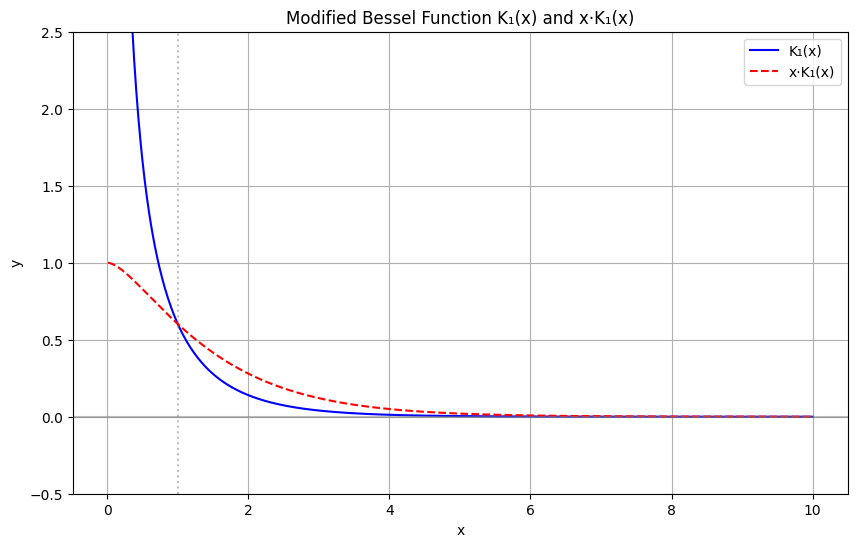

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import k1  # k1 is the modified Bessel function K₁

# Create x values (avoiding x=0 since K1 diverges there)
x = np.linspace(0.01, 10, 1000)

# Calculate K1(x) and x*K1(x)
K1_x = k1(x)
xK1_x = x * k1(x)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot both functions
plt.plot(x, K1_x, 'b-', label='K₁(x)')
plt.plot(x, xK1_x, 'r--', label='x·K₁(x)')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Modified Bessel Function K₁(x) and x·K₁(x)')
plt.grid(True)
plt.legend()

# Add vertical line at x=1 for reference
plt.axvline(x=1, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

# Set y-axis limits to better show the behavior
plt.ylim(-0.5, 2.5)

plt.savefig('bessel_functions.png')
plt.show()